In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from cartopy import crs as ccrs
import cartopy.io.shapereader as shpreader

In [89]:
home = "/Users/frankietucci/Documents/Schoolwork/Spring 2024/CSC 498/498-fat5-trade-analysis/data/"

# We will be using data from 2022 for our analysis, since this is the last complete year provided by the DOT.
data = pd.read_csv(home + "FAF5.5.1_2018-2022.csv")
columns = ["fr_orig", "dms_orig", "dms_dest", "fr_dest", "fr_inmode", "dms_mode", "fr_outmode", "sctg2", "trade_type", "tons_2022", "current_value_2022"]
data = data[columns]

# Domestic-only
dms_data = data[data["trade_type"] == 1]

dms_data

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2022,current_value_2022
0,NaN,11,11,NaN,NaN,1,NaN,1,1,56.472318,101.137720
1,NaN,11,19,NaN,NaN,1,NaN,1,1,426.914113,764.571441
2,NaN,11,129,NaN,NaN,1,NaN,1,1,1.506121,2.697352
3,NaN,11,131,NaN,NaN,1,NaN,1,1,13.826992,24.763115
4,NaN,11,139,NaN,NaN,1,NaN,1,1,5.684208,10.179995
...,...,...,...,...,...,...,...,...,...,...,...
522747,NaN,560,551,NaN,NaN,1,NaN,43,1,0.014564,0.048644
522748,NaN,560,551,NaN,NaN,5,NaN,43,1,0.000049,0.000130
522749,NaN,560,559,NaN,NaN,1,NaN,43,1,0.148435,0.495793
522750,NaN,560,560,NaN,NaN,1,NaN,43,1,165.655865,463.291163


In [90]:
# Merge commodity names
commodity_df = pd.read_csv(home + "commodity_names.csv")
dms_data = pd.merge(dms_data, commodity_df, left_on="sctg2", right_on="Numeric Label")
dms_data.rename(columns={"Description": "commodity_name"}, inplace=True)
del dms_data["Numeric Label"]

# Merge transportation mode
mode_df = pd.read_csv(home + "mode_names.csv")
dms_data = pd.merge(dms_data, mode_df, left_on="dms_mode", right_on="Numeric Label")
dms_data.rename(columns={"Description": "mode_name"}, inplace=True)
del dms_data["Numeric Label"]

# Merge state/metro area names
cfs_df = pd.read_csv(home + "cfs_names.csv")
cfs_df = cfs_df[["FAF", "CFSMA", "CFSAREANAM", "SHORTNAME", "STPOSTAL"]]
cfs_df = cfs_df[cfs_df["CFSMA"] != 99999]
cfs_df = cfs_df[cfs_df["STPOSTAL"].isin(["CO", "ID", "MT", "NV", "UT", "WY", "AK", "CA", "HI", "OR", "WA", "AZ", "NM"])]
dms_data = pd.merge(dms_data, cfs_df, left_on="dms_orig", right_on="FAF")
dms_data.rename(columns={"CFSMA": "CFSMA_orig", "CFSAREANAM": "placename_orig", "SHORTNAME": "short_placename_orig", "STPOSTAL": "abbr_orig"}, inplace=True)
del dms_data["FAF"]
dms_data = pd.merge(dms_data, cfs_df, left_on="dms_dest", right_on="FAF")
dms_data.rename(columns={"CFSMA": "CFSMA_dest", "CFSAREANAM": "placename_dest", "SHORTNAME": "short_placename_dest", "STPOSTAL": "abbr_dest"}, inplace=True)
del dms_data["FAF"]

# Must be a food item
dms_data = dms_data[dms_data["sctg2"].isin(range(8))]
dms_data

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2022,...,commodity_name,mode_name,CFSMA_orig,placename_orig,short_placename_orig,abbr_orig,CFSMA_dest,placename_dest,short_placename_dest,abbr_dest
0,NaN,41,61,NaN,NaN,1,NaN,1,1,62.325348,...,Live animals/fish,Truck,38060,"Phoenix-Mesa-Glendale, AZ CFS Area",Phoenix,AZ,348,"Los Angeles-Long Beach, CA CFS Area",Los Angeles,CA
1,NaN,42,61,NaN,NaN,5,NaN,1,1,0.000051,...,Live animals/fish,Multiple modes & mail,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,348,"Los Angeles-Long Beach, CA CFS Area",Los Angeles,CA
2,NaN,42,62,NaN,NaN,5,NaN,1,1,0.000051,...,Live animals/fish,Multiple modes & mail,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,472,"Sacramento-Roseville, CA CFS Area",Sacramento,CA
3,NaN,42,64,NaN,NaN,5,NaN,1,1,0.000051,...,Live animals/fish,Multiple modes & mail,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,488,"San Jose-San Francisco-Oakland, CA CFS Area",San Francisco,CA
4,NaN,42,81,NaN,NaN,5,NaN,1,1,0.000051,...,Live animals/fish,Multiple modes & mail,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,216,"Denver-Aurora, CO CFS Area",Denver,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,NaN,532,491,NaN,NaN,1,NaN,7,1,1.015121,...,Other foodstuffs,Truck,440,"Portland-Vancouver-Salem, OR-WA CFS Area (WA ...",Portland (WA),WA,482,"Salt Lake City-Provo-Orem, UT CFS Area",Salt Lake City,UT
1230,NaN,532,491,NaN,NaN,5,NaN,7,1,0.000051,...,Other foodstuffs,Multiple modes & mail,440,"Portland-Vancouver-Salem, OR-WA CFS Area (WA ...",Portland (WA),WA,482,"Salt Lake City-Provo-Orem, UT CFS Area",Salt Lake City,UT
1231,NaN,532,531,NaN,NaN,1,NaN,7,1,16.301226,...,Other foodstuffs,Truck,440,"Portland-Vancouver-Salem, OR-WA CFS Area (WA ...",Portland (WA),WA,500,"Seattle-Tacoma, WA CFS Area",Seattle,WA
1232,NaN,532,532,NaN,NaN,1,NaN,7,1,384.930418,...,Other foodstuffs,Truck,440,"Portland-Vancouver-Salem, OR-WA CFS Area (WA ...",Portland (WA),WA,440,"Portland-Vancouver-Salem, OR-WA CFS Area (WA ...",Portland (WA),WA


In [91]:
dms_top_pairs = dms_data[dms_data["dms_orig"] != dms_data["dms_dest"]]
dms_top_pairs["pair"] = dms_top_pairs["short_placename_orig"] + "-" + dms_top_pairs["short_placename_dest"]
dms_top10_pairs = dms_top_pairs.groupby("pair").sum()["current_value_2022"]
dms_top10_pairs = dms_top10_pairs.reset_index()
dms_top10_pairs = dms_top10_pairs.sort_values(by=["current_value_2022"], ascending=False).reset_index()[["pair", "current_value_2022"]].loc[:9]

dms_top10_pairs

/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_16119/1823464827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dms_top_pairs["pair"] = dms_top_pairs["short_placename_orig"] + "-" + dms_top_pairs["short_placename_dest"]


,pair,current_value_2022
0,Los Angeles-San Diego,6521.650754
1,Los Angeles-San Francisco,4461.735978
2,Los Angeles-Phoenix,2856.624487
3,Seattle-Portland (OR),2854.374604
4,San Francisco-Los Angeles,2729.915370
5,San Francisco-Sacramento,2562.620179
6,Sacramento-San Francisco,2449.902218
7,Fresno-San Francisco,2217.353080
8,Portland (OR)-Seattle,2161.181066
9,Fresno-Los Angeles,2137.365136


In [92]:
dms_top10_bycomod = dms_top_pairs[dms_top_pairs["pair"].isin(dms_top10_pairs["pair"])]
dms_top10_bycomod = dms_top10_bycomod.groupby(["pair", "commodity_name", "sctg2"]).sum()["current_value_2022"]
dms_top10_bycomod = dms_top10_bycomod.reset_index()
dms_top10_bycomod = pd.merge(dms_top10_bycomod, dms_top10_pairs.rename(columns={"current_value_2022": "total"}), on="pair")
dms_top10_bycomod["bottom"] = 0
dms_top10_bycomod.sort_values(by=["total", "sctg2"], ascending=[False, True], inplace=True)
dms_top10_bycomod

,pair,commodity_name,sctg2,current_value_2022,total,bottom
22,Los Angeles-San Diego,Live animals/fish,1,8.722861,6521.650754,0
21,Los Angeles-San Diego,Cereal grains,2,114.075941,6521.650754,0
25,Los Angeles-San Diego,Other ag prods.,3,810.129237,6521.650754,0
20,Los Angeles-San Diego,Animal feed,4,1098.919995,6521.650754,0
23,Los Angeles-San Diego,Meat/seafood,5,1101.394622,6521.650754,0
...,...,...,...,...,...,...
4,Fresno-Los Angeles,Other ag prods.,3,617.989161,2137.365136,0
0,Fresno-Los Angeles,Animal feed,4,84.308089,2137.365136,0
2,Fresno-Los Angeles,Meat/seafood,5,734.877405,2137.365136,0
3,Fresno-Los Angeles,Milled grain prods.,6,279.965280,2137.365136,0


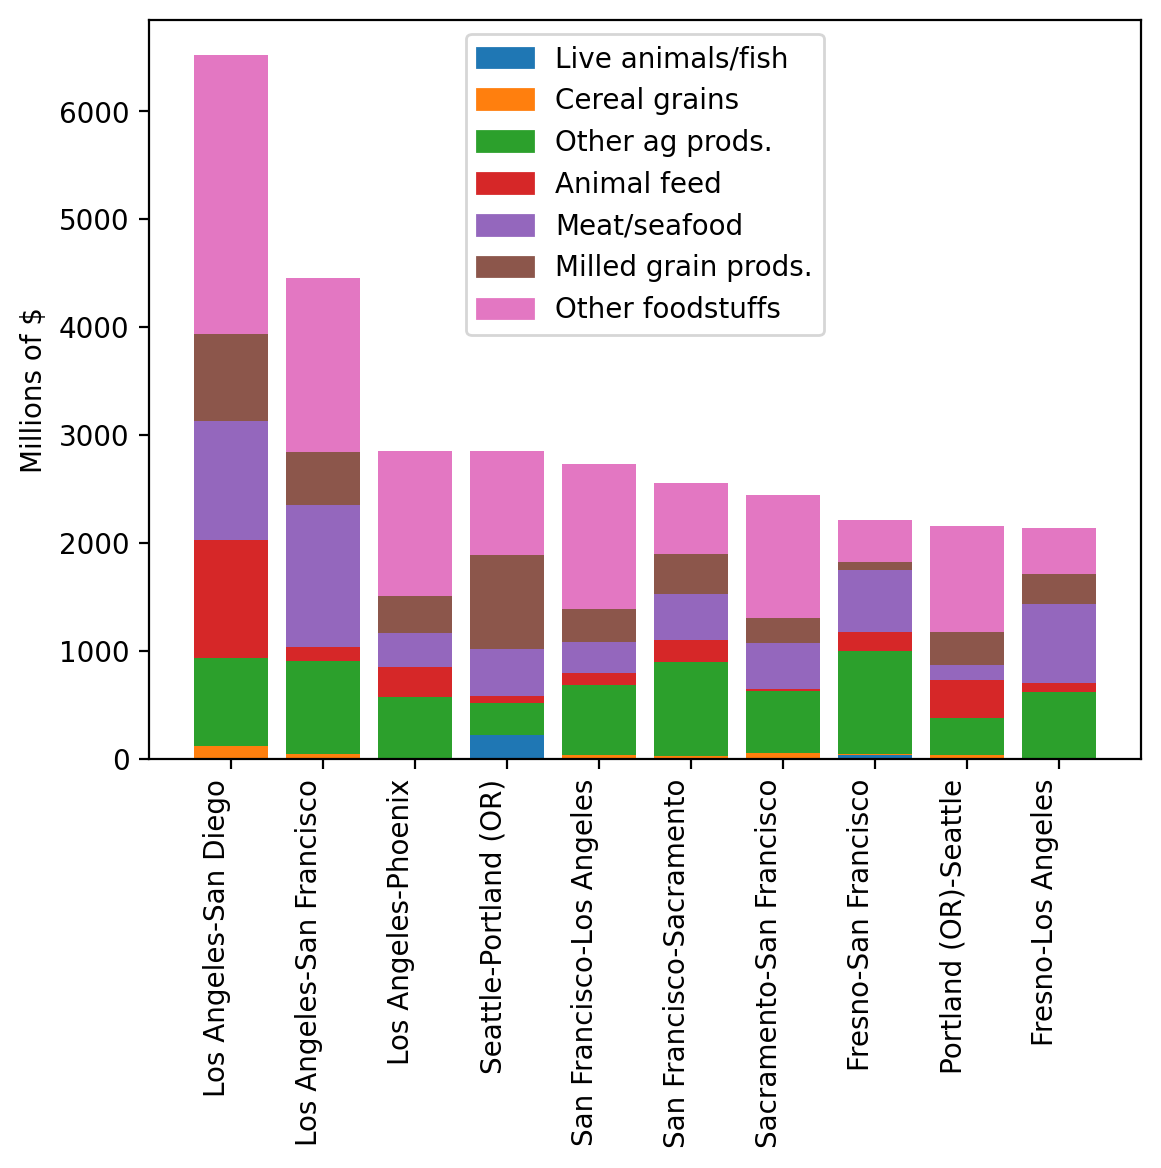

In [93]:
plt.xticks(rotation=90, ha='right')
plt.ylabel("Millions of $")
last = ""
bottom = 0.0

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"]
for i in dms_top10_bycomod.index:
    row = dms_top10_bycomod.loc[i]
    if row["pair"] != last:
        last = row["pair"]
        plt.bar(row["pair"], row["current_value_2022"], bottom=0.0, color=colors[int(row["sctg2"]) - 1])
        bottom = row["current_value_2022"]
    else:
        plt.bar(row["pair"], row["current_value_2022"], bottom=bottom, color=colors[int(row["sctg2"]) - 1])
        bottom += row["current_value_2022"]

patches = []
for i in range(7):
    patches.append(plt.matplotlib.patches.Patch(color=colors[i], label=commodity_df.set_index("Numeric Label").loc[i + 1]["Description"]))

plt.legend(handles=patches, loc="upper center")
plt.show()

In [94]:
placenames = cfs_df["SHORTNAME"].tolist()
dms_pairs_totals = dms_top_pairs.groupby(["pair", "short_placename_orig", "short_placename_dest"]).sum()["current_value_2022"]
dms_pairs_totals = dms_pairs_totals.reset_index()
# Filtering for connections > $10 million
dms_pairs_totals = dms_pairs_totals[dms_pairs_totals["current_value_2022"] > 10.0]

adj_mat = pd.DataFrame(index=placenames, columns=placenames, data=0)

for i in dms_pairs_totals.index:
    row = dms_pairs_totals.loc[i]
    adj_mat.loc[row["short_placename_orig"], row["short_placename_dest"]] = row["current_value_2022"]

adj_mat

/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_16119/2884900682.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '156.801208' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adj_mat.loc[row["short_placename_orig"], row["short_placename_dest"]] = row["current_value_2022"]
/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_16119/2884900682.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.616485' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adj_mat.loc[row["short_placename_orig"], row["short_placename_dest"]] = row["current_value_2022"]
/var/folders/rs/1b7d_4y96s39hlbsx0_qmqyw0000gn/T/ipykernel_16119/2884900682.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a 

,Phoenix,Tucson,Los Angeles,Sacramento,San Diego,San Francisco,Fresno,Denver,Honolulu,Las Vegas,Portland (OR),Salt Lake City,Seattle,Portland (WA)
Phoenix,0.000000,1936.795853,1772.449146,62.659255,164.875944,235.259488,669.874686,130.839424,49.413100,1187.544735,121.536123,234.280791,106.195615,0.000000
Tucson,106.782627,0.000000,660.113895,0.000000,20.720156,57.490028,26.631657,59.467977,0.000000,0.000000,24.345100,35.552146,42.246089,0.000000
Los Angeles,2856.624487,90.407618,0.000000,1309.422135,6521.650754,4461.735978,488.004500,937.366029,739.055132,1331.500461,829.907401,962.176320,1240.744106,191.195783
Sacramento,90.977551,0.000000,864.457255,0.000000,209.300978,2449.902218,474.106912,56.031662,62.678961,30.414939,154.020308,58.780823,303.735506,0.000000
San Diego,243.182325,0.000000,2002.196584,31.944455,0.000000,342.803735,127.721517,65.460656,0.000000,88.465991,82.067739,227.655279,65.691137,0.000000
San Francisco,541.201333,23.550816,2729.915370,2562.620179,149.492333,0.000000,700.734516,417.299356,93.041597,216.221041,422.358721,200.713111,718.884499,48.620763
Fresno,270.645772,0.000000,2137.365136,476.804372,163.205135,2217.353080,0.000000,55.006459,0.000000,11.524432,123.539885,129.869325,278.427004,0.000000
Denver,754.260875,0.000000,649.849296,24.958835,59.743758,164.515847,156.801208,0.000000,0.000000,24.616485,145.780935,637.034712,163.115252,0.000000
Honolulu,0.000000,0.000000,32.499513,0.000000,0.000000,41.482577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Las Vegas,106.722636,0.000000,621.242047,86.213889,38.130334,121.865356,0.000000,32.027544,0.000000,0.000000,15.245849,62.588069,42.312017,0.000000


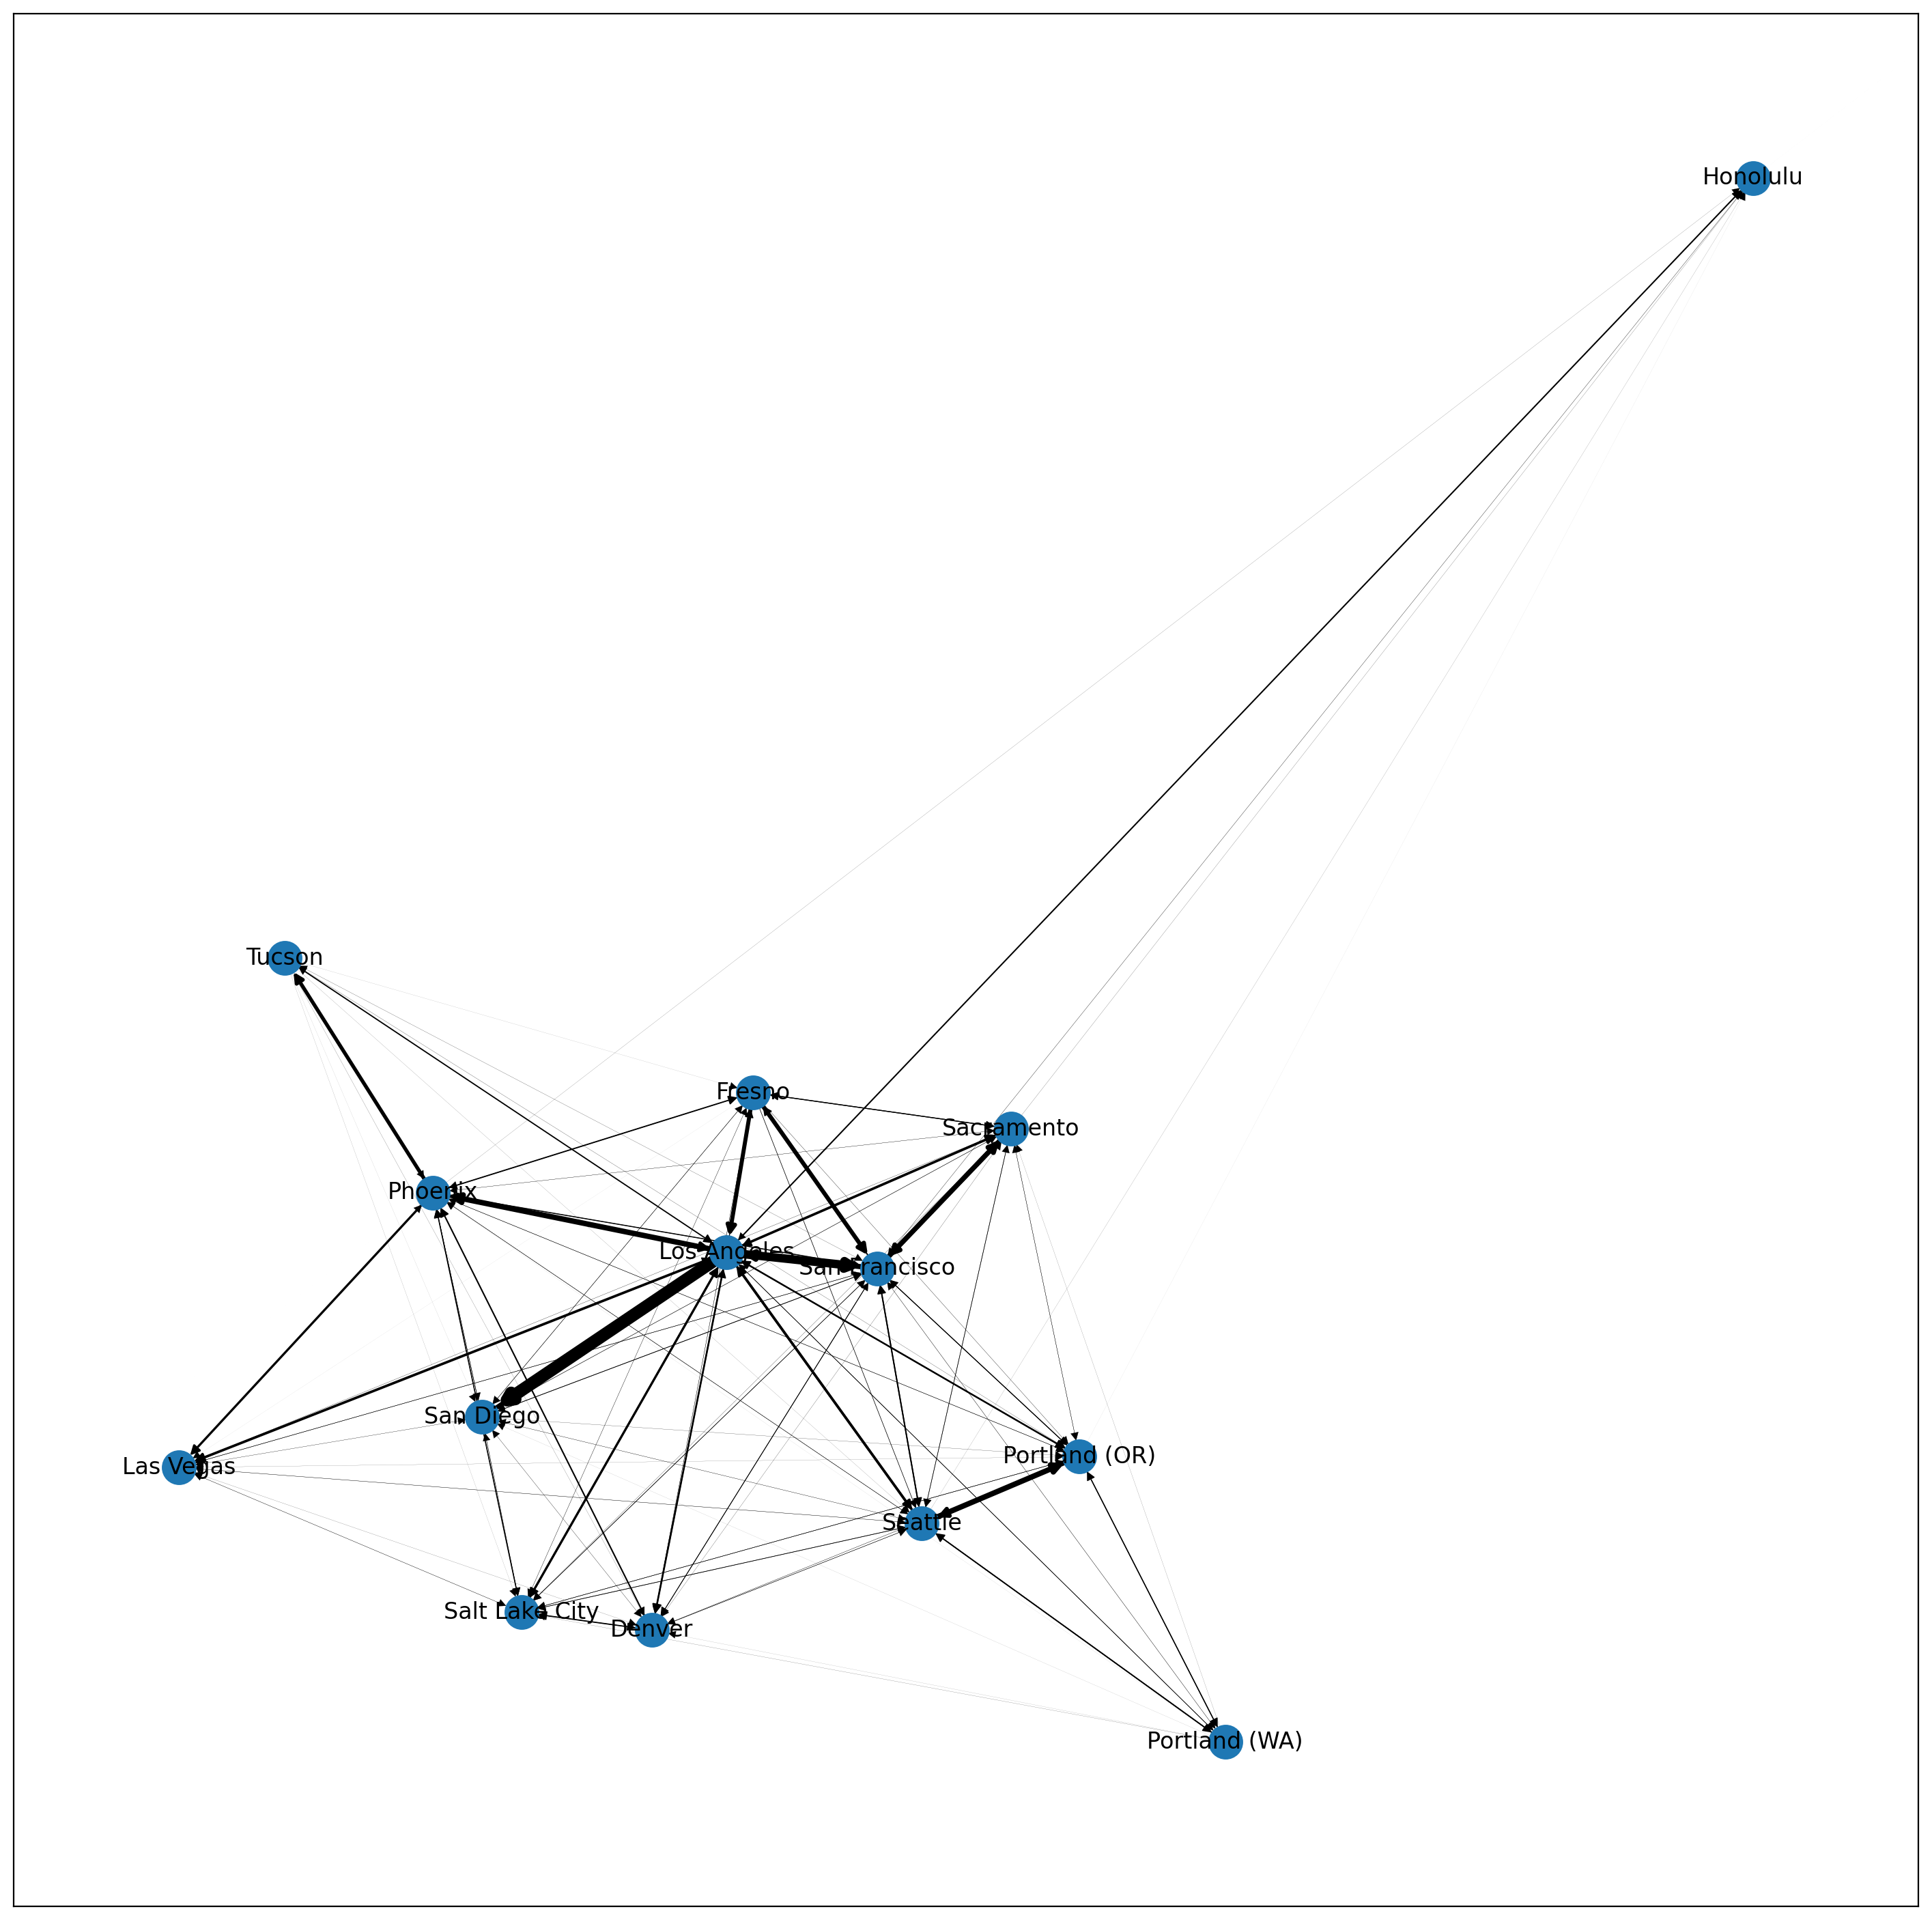

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 3, 2, 1, 0, 2]
1.2307692307692308
0.8766707499999997


In [248]:
G = nx.from_pandas_adjacency(df=adj_mat, create_using=nx.DiGraph())
width = [adj_mat.loc[edge[0], edge[1]] / 1000 for edge in nx.edges(G)]
plt.figure(figsize=(18,18))
nx.draw_networkx(G, arrows=True, width=width)
plt.savefig("output.png", dpi=300)
plt.show()
print(nx.degree_histogram(G))
print(nx.average_shortest_path_length(G))
print(nx.average_clustering(G))

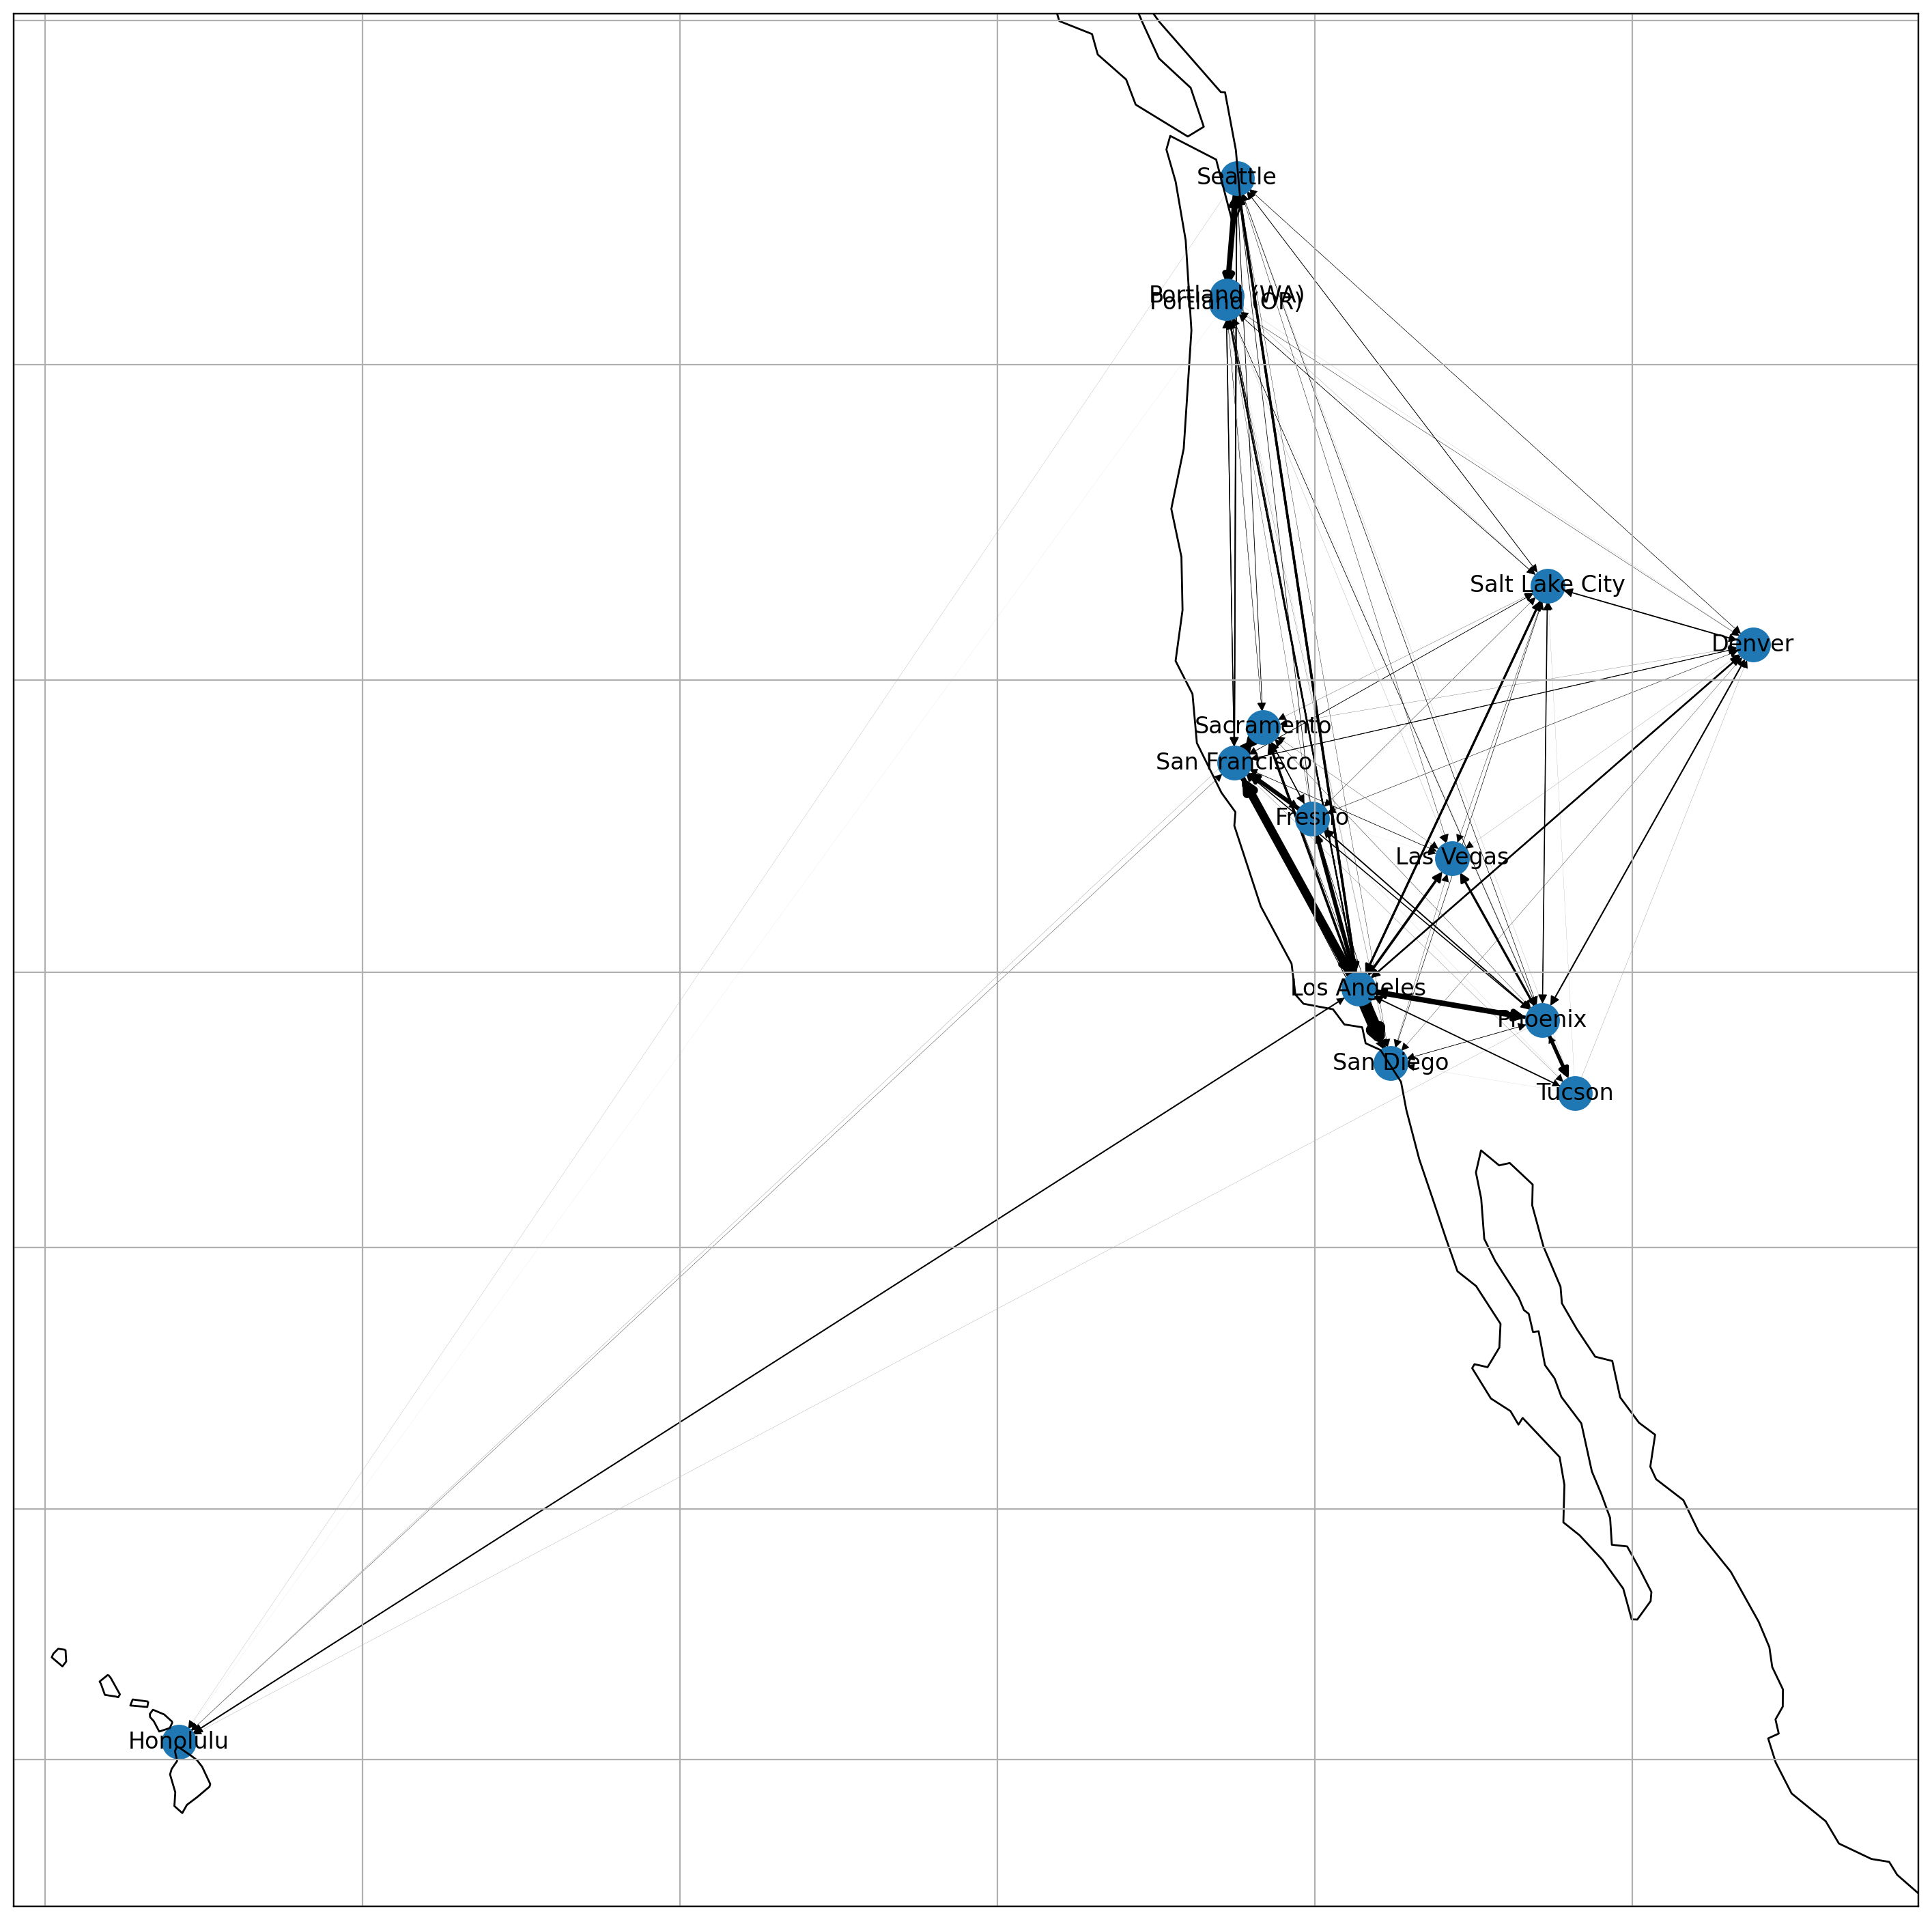

In [383]:
coord_df = pd.read_csv(home + "coordinates.csv")
coord_df.set_index("City", inplace=True)

plt.figure(figsize=(18,18))

states_shp = shpreader.Reader("/Users/frankietucci/Documents/Schoolwork/Spring 2024/CSC 498/498-fat5-trade-analysis/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces")

coords = {}
for item in G.nodes:
    coords[item] = np.array([coord_df.loc[item]["Longitude"], coord_df.loc[item]["Latitude"]])
nx.draw_networkx(G, pos=coords, arrows=True, width=width)

central_lon, central_lat = -131, 17
ax = plt.axes(projection=ccrs.Mercator(central_lon, central_lat))
ax.patch.set_alpha(0)

x_b = 30
y_b = 29
extent = [central_lon - x_b, central_lon + x_b, central_lat - y_b, central_lat + y_b]
ax.set_extent(extent)
ax.set_aspect("auto")
ax.gridlines()
ax.coastlines(resolution='110m')

plt.show()